In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sym
import scipy
from tqdm import tqdm # For clean progress bars

import matplotlib.animation as animation
from IPython.display import HTML # To animate the histogram changes
import ipywidgets as widgets
%matplotlib inline 
# For interactive graphs

In [2]:
def newton_raphson_solver(f, x_0, max_iterations = 100, dx = 1e-3, return_error=False, tolerance = 1e-2):
    # Returns a zero of f given initial condition (x_0,f(x_0)). Modified from standard techniques to fail more gracefully in certain edge cases.
    x_n = x_0
    for i in range(max_iterations):
        f_prime_n = (f(x_n+dx)-f(x_n))/dx
        if f_prime_n == 0:
            raise ZeroDivisionError
        x_n = x_n - f(x_n)/f_prime_n
    return_error = np.abs(f(x_n)) > tolerance 
    if return_error:
        raise ValueError(f(x_n))
    return x_n

newton_raphson_solver(lambda x: np.cos(x)-x, 0) # Should yield about 0.739 if all works correctly

0.7390851332151607

In [3]:
# DEFINITIONS

k_B = 1 # Special units
T_b = 1 # Special units


x_well = 0.5 # Special units
E_barrier = 2*k_B*T_b # J
E_tilt = 1.3*k_B*T_b # J
F_max = 50 # Special Units

asymmetry = 1 # |x_max/x_min|
x_min = -1 # Always negative by convention.
x_max_func = lambda alpha: np.abs(alpha*x_min) 
x_max = x_max_func(asymmetry)

D = 50 # px^2/s
gamma = k_B*T_b/D #0.02

char_time = (x_max-x_min)*gamma/F_max # s (hopefully): Time required to cover the entire domain moving at the maximum velocity, F_max/gamma
expt_length = 6e-2 # s
dt = 1e-5 # s

def U_0(x):
    return 0.5*E_barrier*(1-2*(x/x_well)**2 + (x/x_well)**4) - 0.5*E_tilt*(x/x_well)

y = sym.symbols("y")
dU_0dx = sym.lambdify(y, sym.diff(U_0(y), y))
try:
    x_l = newton_raphson_solver(lambda x: dU_0dx(x) + F_max, x_min, dx=1e-6)
    x_r = newton_raphson_solver(lambda x: dU_0dx(x) - F_max, x_max, dx=1e-6)
except ZeroDivisionError:
     print("Zero slope potential; setting x_l=x_min and x_r=x_max")
     x_l = x_min
     x_r = x_max # Makes it so that the code still works for flat potentials. This is a possible source of error if the code has a lot of opints of inflection: check that x_min and x_max are not maxima/minima.

def U(x, x_l=x_l, x_r=x_r):
#     if x > x_l and x < x_r:
#         return U_0(x)
#     else:
#         if x < x_l:
#             return U_0(x)-F_max*x
#         else:
#             return U_0(x)+F_max*x
    in_well = (x >= x_l) & (x <= x_r)
    left_of_well = (x < x_l)
    right_of_well = (x > x_r)
    # Boolean arrays to determine where the particle is relative to the 'walls'
    
    return U_0(x)*in_well + (U_0(x_l)-F_max*(x-x_l))*left_of_well + (U_0(x_r)+F_max*(x-x_r))*right_of_well

def F(x, x_l = x_l, x_r = x_r):
#     if x > x_min and x < x_max:
#         return -dU_0dx(x)
#     else:
#         if x > x_max:
#             return -F_max
#         else:
#             return F_max 
    return -dU_0dx(x)*((x > x_l) & (x < x_r)) + F_max*(x<=x_l) - F_max*(x>=x_r)

test_range = np.linspace(-2.1, 2.1, 1000)

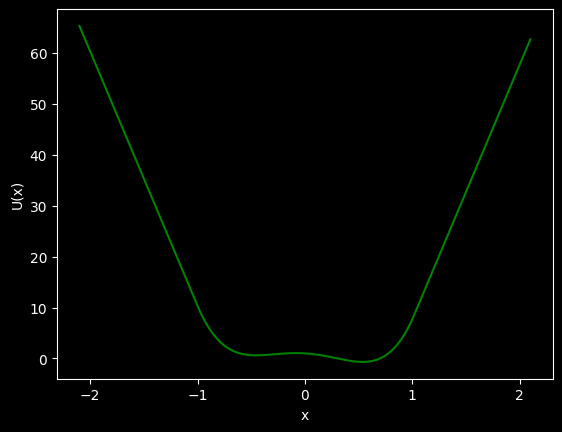

In [4]:
plt.close()
plt.plot(test_range, U(test_range), 'g') # This should be continuous
# plt.plot(test_range, U(test_range), 'r')
plt.ylabel("U(x)")
plt.xlabel("x")
plt.show()

In [5]:
# LANGEVIN SIMULATION

def langevin_simulation(x_0, dt=dt, expt_length = expt_length, force = F, temperature_function=lambda t: T_b, infinite_wall = False, periodic = False, adaptive_timesteps = False, x_min=x_min, x_max=x_max):
    assert not (infinite_wall and periodic), "Infinite BCs and periodic BCs are mutually exclusive!"
    timesteps = round(expt_length/dt)
    # times = np.linspace(0, expt_length, timesteps)
    # ridiculously_high_force = F_max*100
    # if infinite_wall:
    #     new_force = lambda x: force(x)*(~outside_domain(x)) - ridiculously_high_force*(x > x_max) + ridiculously_high_force*(x < x_min)
    # else:
    x = [x_0]
    x_n = x_0
    t = np.arange(0,expt_length, dt)
    D = temperature_function(t)*k_B/gamma
    thermal_fluctuation_std = np.sqrt(2*D*dt)
    stochastic_displacement = np.random.normal(0,thermal_fluctuation_std, size=(*x_0.shape, timesteps))
    
    if adaptive_timesteps:
        def dts(expt_length):
            times = []
            time = 0
            times = []
            dt1=dt
            while time <= expt_length:
                D_0 = T_b*k_B/gamma
                fixed_std = np.sqrt(2*D_0*dt)
                dt1 = (fixed_std**2)/(2*k_B*temperature_function(time)/gamma)
                times.append(dt1)
            return times
        for dt1 in tqdm(dts(expt_length)):
            deterministic_displacement = force(x_n)*dt1/gamma
            # if infinite_wall:
            #     new_x = stochastic_displacement[:,i] + deterministic_displacement + x_n
            #     escaped = outside_domain(new_x, x_min=x_min, x_max=x_max)
            #     stochastic_displacement[:,i] *= ~escaped
            #     stochastic_displacement[:,i] += (new_x > x_max)*(x_max-stochastic_displacement[:,i])
            #     stochastic_displacement[:,i] += (new_x < x_min)*(x_max-stochastic_displacement[:,i])
            x_n = x_n + (deterministic_displacement + np.random.normal(fixed_std, size=x_n.shape))#*((~outside_domain(x_n)) | (~infinite_wall)) + (x_min-x_n)*(x_n < x_min) + (x_max-x_n)*(x_n > x_max)
            # For the moment, no measurement noises are assumed.
            if infinite_wall: # Loose idea for getting the particle back inside the box
                too_high = (x_n > x_max)
                too_low = (x_n < x_min)
                displacement_from_wall = too_high*(x_n-x_max) + too_low*(x_min-x_n)
                multiples_of_domain_size = displacement_from_wall // (x_max-x_min)
                factor = 2*((multiples_of_domain_size+1)//2)
                x_n = inside_domain(x_n)*x_n + too_high*(x_max - (-1)**(multiples_of_domain_size) * (displacement_from_wall-factor*(x_max-x_min))) + too_low*(x_min + (-1)**(multiples_of_domain_size) * (displacement_from_wall-factor*(x_max-x_min)))
            elif periodic:
                too_high = (x_n > x_max)
                too_low = (x_n < x_min)
                displacement_from_wall = too_high*(x_n-x_max) + too_low*(x_min-x_n)
                new_displacement = np.abs(displacement_from_wall) % (x_max-x_min)
                x_n = (~(too_high | too_low))*x_n + too_high*(x_min + new_displacement) + too_low*(x_max-new_displacement)
            x.append(x_n)
            time += dt1
        return np.array(x), dts(expt_length)

    for i in tqdm(range(timesteps)):
        deterministic_displacement = force(x_n)*dt/gamma
        # if infinite_wall:
        #     new_x = stochastic_displacement[:,i] + deterministic_displacement + x_n
        #     escaped = outside_domain(new_x, x_min=x_min, x_max=x_max)
        #     stochastic_displacement[:,i] *= ~escaped
        #     stochastic_displacement[:,i] += (new_x > x_max)*(x_max-stochastic_displacement[:,i])
        #     stochastic_displacement[:,i] += (new_x < x_min)*(x_max-stochastic_displacement[:,i])
        x_n = x_n + (deterministic_displacement + stochastic_displacement[:, i])#*((~outside_domain(x_n)) | (~infinite_wall)) + (x_min-x_n)*(x_n < x_min) + (x_max-x_n)*(x_n > x_max)
        # For the moment, no measurement noises are assumed.
        if infinite_wall: # Loose idea for getting the particle back inside the box
            too_high = (x_n > x_max)
            too_low = (x_n < x_min)
            displacement_from_wall = too_high*(x_n-x_max) + too_low*(x_min-x_n)
            multiples_of_domain_size = displacement_from_wall // (x_max-x_min)
            factor = 2*((multiples_of_domain_size+1)//2)
            x_n = inside_domain(x_n)*x_n + too_high*(x_max - (-1)**(multiples_of_domain_size) * (displacement_from_wall-factor*(x_max-x_min))) + too_low*(x_min + (-1)**(multiples_of_domain_size) * (displacement_from_wall-factor*(x_max-x_min)))
        elif periodic:
            too_high = (x_n > x_max)
            too_low = (x_n < x_min)
            displacement_from_wall = too_high*(x_n-x_max) + too_low*(x_min-x_n)
            new_displacement = np.abs(displacement_from_wall) % (x_max-x_min)
            x_n = (~(too_high | too_low))*x_n + too_high*(x_min + new_displacement) + too_low*(x_max-new_displacement)
        x.append(x_n)
    return x

# DISTANCE FUNCTIONS

def L1(vec1, vec2, axis=None):
    assert len(vec1) == len(vec2), f"Mismatch between vec1 {np.array(vec1).shape} and vec2 {np.array(vec2).shape}"
    return np.sum(np.abs(vec2-vec1), axis=axis)

def helper(element):
    # Avoids issues with taking the log of 0.
    if element == 0:
        return 0
    else:
        return np.log(element)
log_ish = np.vectorize(helper)

def kullback_leibler(vec1, vec2):    
    assert len(vec1) == len(vec2)
    return np.sum(vec1*log_ish(vec1) - vec1*log_ish(vec2))

100%|██████████| 6000/6000 [00:05<00:00, 1078.48it/s]


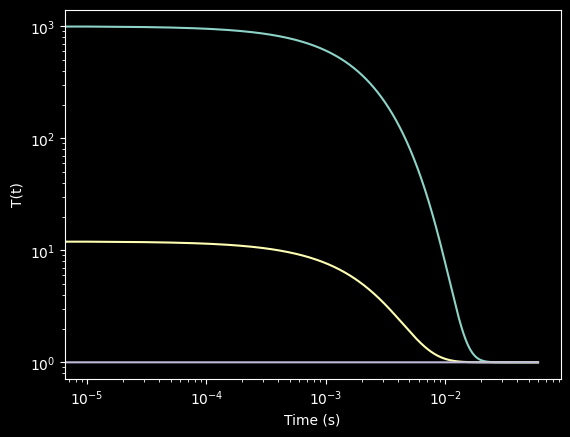

In [55]:
plt.close()
asymmetry = 3
x_max = x_max_func(asymmetry)
# try:
x_l = newton_raphson_solver(lambda x: dU_0dx(x) + F_max, x_min, dx=1e-6)
x_r = newton_raphson_solver(lambda x: dU_0dx(x) - F_max, x_max, dx=1e-6)
keys = ['h','w','c','f']
temperature = {}
# Ensemble
temperature['h'] = T_b * 1000
temperature['w'] = T_b * 12
temperature['c'] = T_b * 1
# temperature['f'] = T_b * 1e-1 # "Frozen" -- can this 'heat' up?
unnormalised_boltzmann = lambda x, T: np.exp(-U(x, x_l=x_l, x_r=x_r)/(k_B*T))
active_range = np.linspace(x_min, x_max, 10000)
dx = (x_max-x_min)/10000
N = 10_000

# lambda2 = 2.06439 # /s -- computed analytically
# lambda3 = 33.1032 # /s

lambda_2 = 286 # 2.86147510e+02? Estimated from curve fit

tau = 200*dt
times = np.arange(0, 6e-2, dt)

boltzmann = lambda x, T: unnormalised_boltzmann(x, T)/np.sum(unnormalised_boltzmann(x,T))

initial_distro = {T: boltzmann(active_range, temperature[T]) for T in temperature}
results = {}
dts = {}

def exponential_decay(t, tau, T='h', T_b=T_b):
    if tau == 0:
        if type(t) == np.ndarray: return T_b*np.ones(t.shape)
        return T_b
    return (temperature[T]-T_b)*np.exp(-t/tau) + T_b

def initial_position(x_range, num_particles, p):
    return np.random.choice(x_range, num_particles, p=p)

# for trial in tqdm(range(N)):
for T in temperature:
    # x = np.zeros(N) # Delta function initial condition (for diffusion test)
    x = initial_position(active_range, N, p=initial_distro[T])
    temperature_function = lambda t: exponential_decay(t, tau, T=T)
    results[T] = langevin_simulation(x, temperature_function=temperature_function, adaptive_timesteps=False, periodic=False, x_min=x_min, x_max=x_max)
    results[T] = np.array(results[T]).T
    plt.loglog(times, temperature_function(times))
plt.xlabel("Time (s)")
plt.ylabel("T(t)")
plt.show()

In [56]:
# times = {T: np.cumsum(dts[T]) for T in dts}
results['h'].shape

(10000, 6001)

In [57]:
# %matplotlib inline
BINS = 100

binned_active_domain = np.linspace(x_min, x_max, BINS)
# binned_active_range = binned_active_domain
global_min = np.min(results['h'])
global_max = np.max(results['h'])
inefficiency = (global_max-global_min)/(x_max-x_min)
print(f"Inefficiency = {inefficiency}")
if inefficiency < 1:
    inefficiency = 1
    global_min = x_min
    global_max = x_max
# elif inefficiency < 1.5:
#     global_min = x_min
#     global_max = x_max
    
binned_active_range = np.linspace(global_min, global_max, round(BINS*inefficiency))



if not (inefficiency > 100):
    unnormalised_distro_init = {T: unnormalised_boltzmann(binned_active_range, temperature[T]) for T in temperature}
    binned_initial_distro = {T: unnormalised_distro_init[T]/np.sum(unnormalised_distro_init[T]) for T in temperature}

    unnormalised_distro_fin = unnormalised_boltzmann(binned_active_range, T_b)
    binned_final_distro = unnormalised_distro_fin/np.sum(unnormalised_distro_fin)

    heights_init, bins_init = {}, {}
    heights_fin, bins_fin = {}, {}
    heights_mid, bins_mid = {}, {}

    for T in temperature:
        heights_init[T], bins_init[T] = np.histogram(results[T][:,0], bins=binned_active_range)
        heights_mid[T], bins_mid[T] = np.histogram(results[T][:,100], bins=binned_active_range)
        heights_fin[T], bins_fin[T] = np.histogram(results[T][:,-1], bins=binned_active_range)
# plt.hist(results['h'].T[-1], bins='auto', density=True)
# plt.hist(results['h'].T[0])
# plt.plot(active_range, final_distro, 'w')

Inefficiency = 20.967295976373286


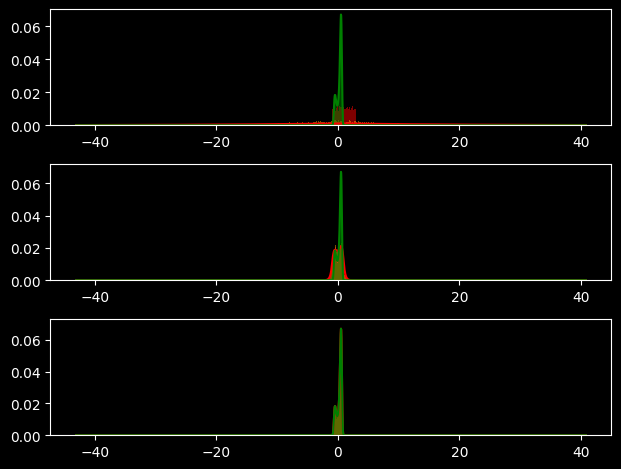

In [58]:
"""Sanity checks: The initial and final distributions should match the Boltzmann distro"""
%matplotlib inline
plt.close()
fig, ax = plt.subplots(len(temperature))
vals = list(temperature.keys()) 

for i in range(len(temperature)):
    ax[i].bar(bins_init[vals[i]][:-1], heights_init[vals[i]]/N, width=bins_init[vals[i]][1]-bins_init[vals[i]][0], alpha=0.5, color='r')
    ax[i].bar(bins_mid[vals[i]][:-1], heights_mid[vals[i]]/N, width=bins_fin[vals[i]][1]-bins_fin[vals[i]][0], alpha=0.5, color='orange')
    ax[i].bar(bins_fin[vals[i]][:-1], heights_fin[vals[i]]/N, width=bins_fin[vals[i]][1]-bins_fin[vals[i]][0], alpha=0.5, color='g')
    # plt.hist(results[-1], bins=50)
    ax[i].plot(binned_active_range, binned_initial_distro[vals[i]], 'r')
    ax[i].plot(binned_active_range, binned_final_distro, 'g')

plt.tight_layout()
plt.show()

In [59]:
# plt.plot(times['h'], results['h'][np.random.choice(N),:-1])

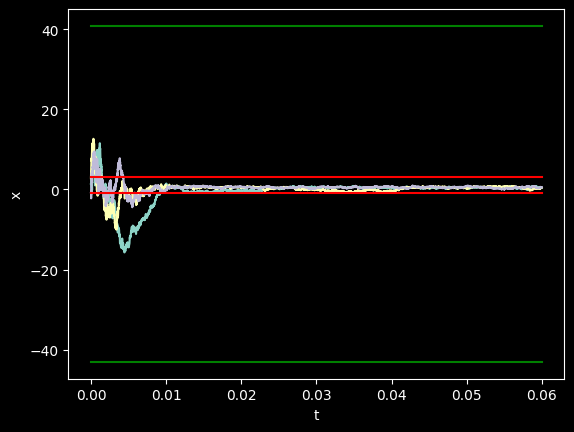

Inefficiency = 20.967295976373286


In [60]:
plt.close()
%matplotlib inline
plt.plot(times, results['h'][np.random.choice(N),:-1])
plt.plot(times, results['h'][np.random.choice(N)+1,:-1])
plt.plot(times, results['h'][np.random.choice(N)+2,:-1])
# plt.plot(results['h'][np.random.choice(N)+3,:])
plt.plot([0,expt_length],[[x_min,x_max], [x_min, x_max]], 'r')
plt.plot([0,expt_length],[[global_min,global_max], [global_min,global_max]], 'g')
plt.xlabel("t")
plt.ylabel("x")
plt.show()
print(f"Inefficiency = {inefficiency}")

In [52]:
distances = {}
heights = {}
for T in temperature:
    heights[T] = np.apply_along_axis(lambda x: np.histogram(x, bins=binned_active_range)[0], axis=0, arr=results[T])
    reshaped_final_distro = np.reshape(binned_final_distro[:-1],(len(binned_final_distro)-1,1)) # We reshape the final distro like this so we can vectorise the L1 distance: this turns it from a size=(n-1) array into a ((n-1),1) size array that you can subtract from a size ((n-1), number_of_timesteps) array without errors.
    distances[T] = L1(heights[T]/N, reshaped_final_distro, axis=0)
    # Vectorised: about 2x faster than below unvectorised code.

    # Height, Bin = {}, {}
    # for i in tqdm(range(results[T].shape[1])):
    #     Height[T], Bin[T] = np.histogram(results[T][:,i], bins=binned_active_range)
    #     distances[T].append(L1(Height[T]/N, binned_final_distro[:-1]))

In [53]:
# %matplotlib widget
if np.mean((heights['h'].sum(axis=0)/N)) != 1:
    plt.close(); plt.plot((heights['h'].sum(axis=0))/N); plt.show()
else:
    print("No particle escapes!")

No particle escapes!


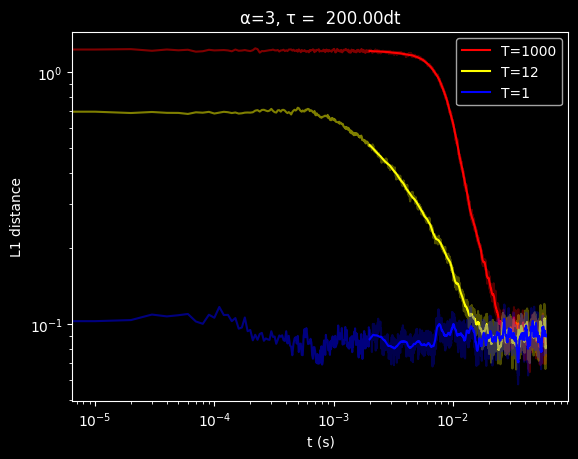

In [54]:
plt.close()
def moving_average(noisy_data, window=10):
    # Smoothens noisy data. Larger window sizes will mean smoother data, at the cost of less resolution.
    length = len(noisy_data)
    outs = []
    for i in range(length):
        outs.append(np.average(noisy_data[max(i-window//2, 0): min(i+window//2, length)]))
    return outs

colours = {'h': 'red', 'w': 'yellow', 'c': 'blue', 'f': 'cyan'}
total_time = round(expt_length/dt) # iterations --- after this point there's only noise

start_time, end_time, window = 200, total_time, 70
times = np.array(range(total_time))*dt
plt.title(f"α={asymmetry}, τ = {tau/dt : .2f}dt") # 1/λ_2 = 
plt.ylabel("L1 distance")
plt.xlabel("t (s)")
for T in temperature:
    plt.loglog(times[times<start_time*dt], distances[T][:start_time], color = colours[T], alpha=0.5)
    plt.loglog(times[times>=start_time*dt], distances[T][start_time:end_time], color = colours[T], alpha=0.3)
    plt.loglog(times[times>=start_time*dt], moving_average(distances[T], window=window)[start_time:end_time], color = colours[T], label=f"T={temperature[T]}")
plt.legend()
plt.show()

C:\tools\Manim\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[1.34948222e-01 2.24823619e+04 2.23404691e+03 0.00000000e+00
 1.00000000e+03]


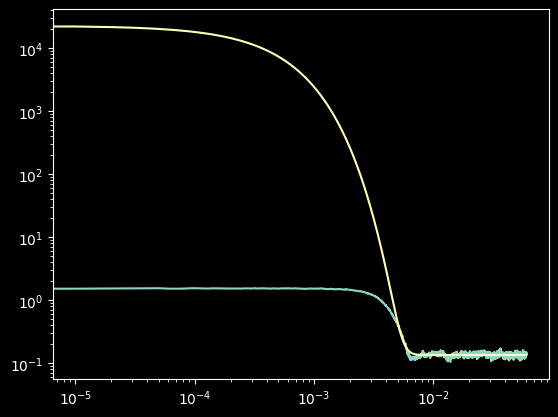

In [18]:
plt.close()
%matplotlib inline
def approximate_solution(t, noise_floor, coeff_2, lambda_2, coeff_3, lambda_3):
    return noise_floor + coeff_2*np.exp(-lambda_2*t) + 0*coeff_3*np.exp(-lambda_3*t)
# plt.loglog(times, approximate_solution(times, distances['c'].mean(), distances['h'][0] - distances['c'].mean(), 0))
plt.loglog(times, distances['h'][:-1])
start, window = 500, 6000
params, covariance = scipy.optimize.curve_fit(approximate_solution, times[start:window], distances['h'][start:window], p0=[distances['c'].mean(), distances['h'][0] - distances['c'].mean(), 100, 
0, 1000], maxfev = 10000)
print(params)
# print(covariance)
plt.loglog(times, approximate_solution(times, *params))
# plt.plot([1e-5, 6e-2], [params[0], params[0]])
plt.show()

### Predicted $\lambda_2$, $\lambda_3$ values (for T_h = 1000):


Fit: $\Delta\mathcal D \sim \sigma_{\mathcal D} + C_2e^{-\lambda_2 t}$
-----------------------------------------------------
| $\alpha$ | $C_2$ | $\lambda_2$ | $C_3$ | $\lambda_3$ | $\sigma_{\mathcal D}$ |
|----------|-------|-------------|-------|-------------|------------|
| 1 | 0.4575 | 226.3 | - | - | 0.09851 |
| 1.3 | 0.3132 | 237.1 | - | - | 0.09265 |
| 3 | 0 | - | 1.286 | 1597 | 0.07839 |
| 6 | 1.504 | 805.8 | - | - | 0.08782 |
| 9 | 1.552 | 709.5 | - | - | 0.1901 |

Fit: $\Delta\mathcal D \sim \sigma_{\mathcal D} + C_2e^{-\lambda_2 t} + C_3 e^{-\lambda_3 t}$
-----------------------------------------------------
| $\alpha$ | $C_2$ | $\lambda_2$ | $C_3$ | $\lambda_3$ | $\sigma_{\mathcal D}$ |
|----------|-------|-------------|-------|-------------|------------|
| 1 | 0.4532 | 225.9 | 0.2218 | 10016 | 0.09938 |
| 1.3 | 0.3018 | 248.8 | 0.4836 | 4492 |  0.09264 |
| 3 | 0 | - | 1.286 | 1597 | 0.07839 |
| 6 | 1.566 | 193.9 | 1.387 | 930.1 | 0.08401 |
| 9 | 1.107 | 144.8 | 1.527 | 642.6 | 0.1072 |

In [ ]:

import pandas as pd

names = {'c': './alpha3_data/L1_cold.txt',
         'w': './alpha3_data/L1_warm.txt',
         'h': './alpha3_data/L1_hot.txt'}
data = {T: pd.read_table(names[T]) for T in ['c', 'w', 'h']}
simulation_names = {alpha: f"FPE_simulation_alpha{alpha}T_h1000T_w12.csv" for alpha in [1,1.3,3,6,9]}
simulation_data = {alpha: pd.read_csv(simulation_names[alpha]) for alpha in [1,1.3,3,6,9]}

In [ ]:
plt.close()
key = 'h'
alpha=asymmetry


# plt.semilogy(moving_average(distances[key], window=100)[:time_window], color = 'r')
# plt.semilogx(times, distances[key][:-1], color = 'r', alpha=.7)
# plt.semilogy(moving_average(data[key], window=100)[:time_window], color = 'g')
plt.semilogx(times, data[key][:-2], color = 'lime', alpha=.7, label = "Data (N=1,000)")
plt.semilogx(times, distances['h'][:-1], label="Langevin simulation (N=1,000)")
plt.semilogx(simulation_data[alpha]['t'], simulation_data[alpha]['D']-0.09, color="r", label = "Fokker-Planck simulation")
plt.legend()
plt.show()

In [ ]:
simulation_data['D'][0]

|T   | Value     | Exact | Simulated (N=50,000) | Experimental | 
|----|---------|-------------------| --------| -------- |
|$\sim T_\infty$ | $(2^{62} -1)T_b$ | 1.3204462627276485 | NA | NA |
|$T_h$ | $1000T_b$ | 1.2032851931580588 | 1.2000941778266312 | 1.2472471 |
|$T_w$ | $12T_b$   | 0.7948224781813559 | 0.7975410636077775 | 0.7587586 |
|$T_c$ | $T_b$     | 0.0               | 0.11996244969059888 | 0.15615606 |

**For $\alpha=3$, L1 distances**

In [ ]:
T = 'h'

L1(binned_initial_distro[T], binned_final_distro)#, data[T]['L1_cold'][0]
# plt.plot(binned_final_distro)

In [ ]:
temps = 2**np.arange(0,63,1, dtype=np.float64)
distros = np.array([unnormalised_boltzmann(binned_active_range, temp) for temp in temps])
new = np.divide(distros.T, np.sum(distros, axis=1)).T

distances = np.array([L1(binned_final_distro[:], new[T, :]) for T in range(len(temps))])
plt.semilogx(temps, distances)
temps[-1], distances[-1]

In [64]:
# ANIMATION: UNCOMMENT THE LINES BELOW TO ANIMATE THE VIDEOS

# fig = plt.figure()
# ims = []
T = 'h'

new_binned_active_range = np.linspace(x_min, x_max, 50)
new_unnormalised_initial_distro = unnormalised_boltzmann(new_binned_active_range, temperature[T])
new_binned_initial_distro = new_unnormalised_initial_distro/np.sum(new_unnormalised_initial_distro)
new_unnormalised_initial_distro_w = unnormalised_boltzmann(new_binned_active_range, temperature['w'])
new_binned_initial_distro_w = new_unnormalised_initial_distro/np.sum(new_unnormalised_initial_distro)
new_unnormalised_final_distro = unnormalised_boltzmann(new_binned_active_range, temperature['c'])
new_binned_final_distro = new_unnormalised_final_distro/np.sum(new_unnormalised_final_distro)

fig, ax = plt.subplots()
heights, bins = np.histogram(results[T][:0], bins=new_binned_active_range)
patches = ax.bar(bins[:-1], heights/N, width=bins[1]-bins[0], alpha=0.5, color='r')
ax_height = np.max(new_binned_final_distro + 0.02)
ax.set_ylim(0,ax_height)
temperature_function= lambda t: (temperature[T]-T_b)*np.exp(-t/tau)+T_b

set_const_height = True
set_moving_height = False
plot_analytic_solution = False
plot_warm_temperatures = False

# animated_frames = [i for i in range(20)] + [i for i in range(20,60, 2)] + [i for i in range(60,360, 5)] + [i for i in range(360,3960, 10)] + [i for i in range(3960,30000, 100)]
num_animated_frames = 500 # Keep it small for efficient rendering
exponential_frame_func = lambda x, x_0: (expt_length/dt)*(np.exp(x/x_0)-1)/(np.exp(num_animated_frames/x_0)-1)
animated_frames = np.rint(exponential_frame_func(np.arange(0,num_animated_frames+1, 1), 100)).astype('int')
# Tiem in the video will be on a log scale, primarily for rendering efficiency


def analytic_solution(x,t):
    unnormalised_soln = np.exp(-binned_active_range**2/(4*D*t))
    return unnormalised_soln/np.sum(unnormalised_soln)

ax.plot(new_binned_active_range, new_binned_initial_distro, 'r')
ax.plot(new_binned_active_range, new_binned_final_distro, 'g')
if plot_warm_temperatures:
    heights, bins = np.histogram(results['w'][:0], bins=new_binned_active_range)
    patches_w = ax.bar(bins[:-1], heights/N, width=bins[1]-bins[0], alpha=0.3)
    ax.plot(new_binned_active_range, new_binned_initial_distro_w, 'g')
    ax.plot(bins[:-1], heights/N)
# Update function for the animation
def update(frame_number):
    # Get the data for the current frame
    # ax.clear()
    heights, bins = np.histogram(results[T][:frame_number], bins=new_binned_active_range)
    if plot_warm_temperatures:
        heights_w, bins_w = np.histogram(results['w'][:frame_number], bins=new_binned_active_range)
        for i in range(len(patches_w)):
            patches_w[i].set_height(heights_w[i]/N)
    # Update the histogram data
    for i in range(len(patches)):
        patches[i].set_height(heights[i]/N)#, width=bins[1]-bins[0], color='y', alpha=0.7)
    ax.set_title(f"Frame = {frame_number}; T = {temperature_function(frame_number*dt):.3f}")
    if set_moving_height:
        if frame_number % 100 == 0:
            ax.set_ylim(0,ax_height)
    elif set_const_height:
        ax.set_ylim(0,ax_height)
    if plot_analytic_solution:
        t = frame_number*dt
        if t != 0:
            ax.plot(binned_active_range, analytic_solution(binned_active_range, t), 'y')
    # for i in range(len(bins)):
    #     patches[i].set_height(heights[i])
    return patches

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=animated_frames, interval=10, blit=True, cache_frame_data=True)
plt.close()

HTML(ani.to_html5_video())

KeyboardInterrupt: 